In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from x2 import X2Env

env = X2Env()

In [3]:
from code.rng import set_seeds, SEED
set_seeds()

/home/guillaume/rainbow-is-all-you-need/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from code.agent import DQNAgent

# parameters
num_frames = 30000
memory_size = 10000
batch_size = 128
target_update = 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, SEED)

26 5
cuda


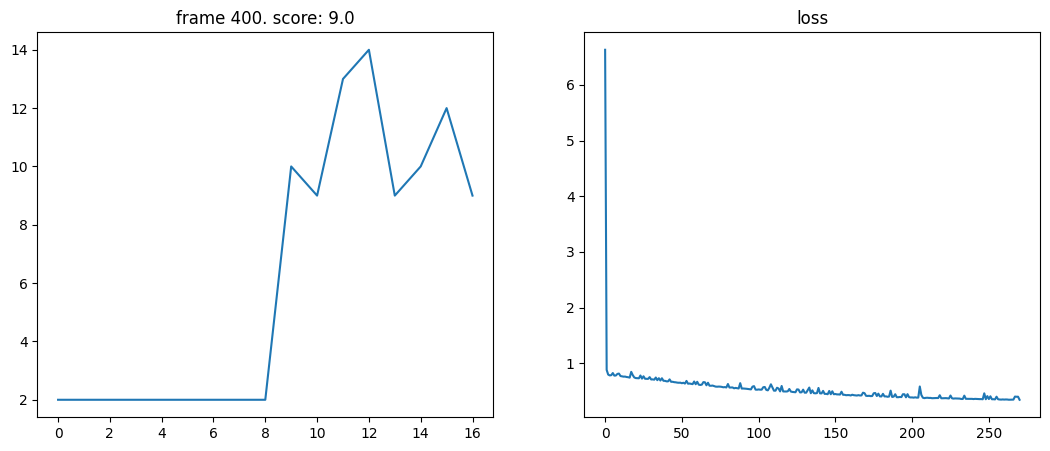

In [5]:
agent.train(num_frames)